# About this notebook 

#### Objective: Predictive Modeling


<div class="span5 alert alert-success">
<p> <I> Predictive Modeling Description: </I> Ultimate is interested in predicting rider retention. To help explore this question, they have provided a sample dataset of a cohort of users (ultimate_data_challenge.json) who signed up for an Ultimate account in January 2014. The data was pulled several months later and they consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.  
 <br>
In this notebook the data is explored and several machine models used to help understand what factors are the best predictors for retention.
 </p>
</div>

<div class="span5 alert alert-success">
<p> The data fields provided are...  
    ●  <I> city: </I> city this user signed up in  
●  <I>phone: </I> primary device for this user  
●  <I>signup_date: </I> date of account registration; in the form ‘YYYY MM DD’  
●  <I>last_trip_date:  </I>the last time this user completed a trip; in the form ‘YYYY MM DD’  
●  <I>avg_dist: </I> the average distance in miles per trip taken in the first 30 days after signup  
●  <I>avg_rating_by_driver: </I> the rider’s average rating over all of their trips  
●  <I>avg_rating_of_driver:  </I>the rider’s average rating of their drivers over all of their trips  
●  <I>surge_pct: </I> the percent of trips taken with surge multiplier > 1  
●  <I>avg_surge: </I> The average surge multiplier over all of this user’s trips  
●  <I>trips_in_first_30_days: </I> the number of trips this user took in the first 30 days after
signing up  
●  <I>ultimate_black_user: </I> TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise  
●  <I>weekday_pct: </I> the percent of the user’s trips occurring during a weekday  
 </p>
</div>

<div class="span5 alert alert-info">
<p> <B>  Imports and Data Loading: </B>  </p>
</div>

In [106]:
import warnings
warnings.filterwarnings('ignore')

%cd C:\Users\Ken\Documents\KenP\Applications-DataScience\SpringboardCourseWork\Section17.1TakeHomeChallenge-UltimateTechnologiesInc\ultimate_challenge

C:\Users\Ken\Documents\KenP\Applications-DataScience\SpringboardCourseWork\Section17.1TakeHomeChallenge-UltimateTechnologiesInc\ultimate_challenge


In [107]:
#Imports
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [108]:
#Import the json data challenge file
with open('ultimate_data_challenge.json', 'r') as json_file:
    json_data = json.load(json_file)

type(json_data)

list

In [109]:
df1 = pd.DataFrame(json_data)
df1.tail(1)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
49999,3.49,5.0,NaN,1.0,Astapor,2014-04-20,Android,2014-01-18,0.0,0,False,0.0


<div class="span5 alert alert-info">
<p> <B>  Missing Data and Cleanup: </B>   

</p>
</div>

In [110]:
# Percentage of missing values in each column
pd.DataFrame(
    df1.isnull().sum() / len(df1),
    columns=['% Missing Values']
).transpose()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
% Missing Values,0.0,0.00402,0.16244,0.0,0.0,0.0,0.00792,0.0,0.0,0.0,0.0,0.0


In [111]:
#drop any row that has NaN value and show resulting counts
df2 = df1.dropna(how='any')

In [112]:
# Percentage of missing values in each column now that NaN values are removed.
pd.DataFrame(
    df2.isnull().sum() / len(df2),
    columns=['% Missing Values']
).transpose()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
% Missing Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
#Convert date columns to a datetime column in pandas
df2['last_trip_date'] = pd.to_datetime(df2['last_trip_date'])
df2['signup_date'] = pd.to_datetime(df2['signup_date'])

In [114]:
#Change ultimate_black column to a "1" for true and a "0" for false
df2['ultimate_black_user_num'] = np.where(df2.ultimate_black_user == 1, 1, 0)
df2 = df2.drop(['ultimate_black_user'],axis=1)

In [115]:
#Convert city to numeric values: Astapor = 1, King's Landing = 2, Winterfell = 3
df2['city_numeric'] = np.where(df2.city == 'Astapor',1,np.where(df2.city == 'Winterfell',3,2))
df2 = df2.drop(['city'],axis=1)

In [116]:
#Convert phone model to numeric values: 1 = Android, 2 = iphone
df2['phone_numeric'] = np.where(df2.phone == 'Android',1,2)
df2 = df2.drop(['phone'],axis=1)

In [117]:
#Add a Retained column: defined as a ride was taken in June is a value of 1, no ride taken is 0
df2['retained'] = np.where(df2.last_trip_date.dt.month == 6, 1, 0)

In [118]:
df2.head(2)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,weekday_pct,ultimate_black_user_num,city_numeric,phone_numeric,retained
0,3.67,5.0,4.7,1.1,2014-06-17,2014-01-25,15.4,4,46.2,1,2,2,1
1,8.26,5.0,5.0,1.0,2014-05-05,2014-01-29,0.0,0,50.0,0,1,1,0


In [119]:
#Write dataframe to a csv file
out_csv = 'ultimatedatafields.csv'
df2.to_csv(out_csv)

<div class="span5 alert alert-info">
<p> <B>  Visualize the Data: </B>   

</p>
</div>

<div class="span5 alert alert-success">
<p> Describe and visualize the data for trends
 </p>
</div>

In [120]:
#Calculate the fraction of the observed users that were retained
#Retained = all riders who took at least one trip in June
ridersinjunecount = df2.retained[df2.retained > 0].count() 

totalriderscount = df2.signup_date.count()

fractionretained = ridersinjunecount/totalriderscount

print("total signed up: " + str(ridersinjunecount))
print("total who rode in June: " + str(totalriderscount))
print()
print("fraction retained: " + str(fractionretained))

total signed up: 16506
total who rode in June: 41445

fraction retained: 0.39826275787187837


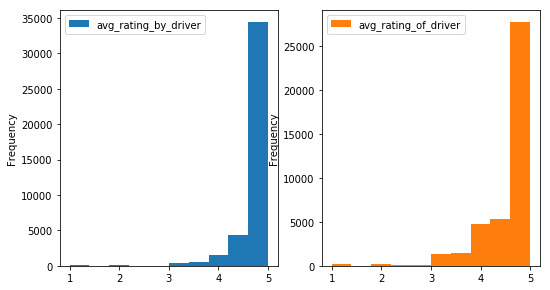

In [121]:
#Create histograms of the ratings fields
dfhist = df2[['avg_rating_by_driver','avg_rating_of_driver']]

dfhist.plot(figsize=(18, 16), kind='hist', subplots=True, layout=(3,4), sharex=False)
plt.show()

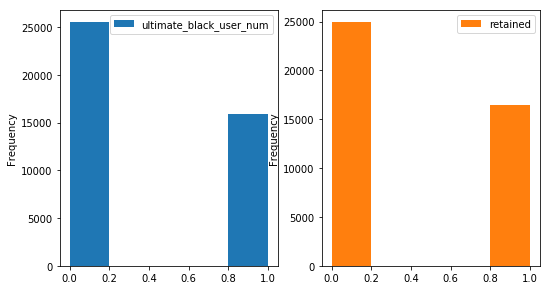

In [122]:
#Create histograms of the true/false (0,1) fields
dfhist2 = df2[['ultimate_black_user_num','retained']]

dfhist2.plot(figsize=(18, 16), kind='hist', bins=5, subplots=True, layout=(3,4), sharex=False)
plt.show()

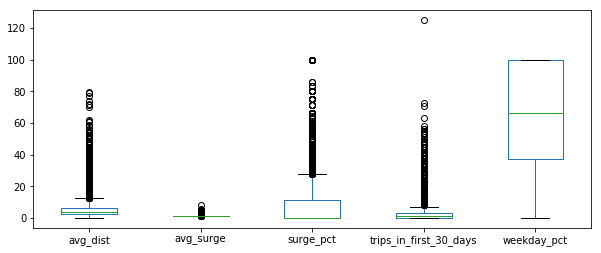

In [123]:
#Create a box plot for reference if needed
dfbox = df2[['avg_dist','avg_surge','surge_pct','trips_in_first_30_days',
            'weekday_pct']]

dfbox.plot(figsize=(10, 4), kind='box', subplots=False, layout=(1,1), sharex=False, sharey=False)
plt.show()

<div class="span5 alert alert-info">
<p> <B>  Machine Learning: </B> 
Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system.
</p>
</div>

<div class="span5 alert alert-success">
<p> Evaluate which features contribute the most to predicting the target attribute
 </p>
</div>

In [124]:
#Remove last_trip_date from the model because it was used to create the retained feature and the signup_date because it is
#not relevant for prediction.
df3 = df2.drop(['last_trip_date','signup_date'],axis=1)
df3.head(1)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,ultimate_black_user_num,city_numeric,phone_numeric,retained
0,3.67,5.0,4.7,1.1,15.4,4,46.2,1,2,2,1


In [125]:
#Create the array
array = df3.values
X = array[:,0:10]
Y = array[:,10]

In [126]:
#Feature extraction with RFE
model = LogisticRegression()
rfe = RFE(model, 3)
fit = rfe.fit(X, Y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 3
Selected Features: [False False False False False False False  True  True  True]
Feature Ranking: [4 2 6 5 7 3 8 1 1 1]


In [127]:
#Feature extraction with Feature Importance
model = ExtraTreesClassifier()
model.fit(X, Y)
print(model.feature_importances_)

[0.26654498 0.10338486 0.08774643 0.05721623 0.0870787  0.09955347
 0.1478144  0.03994032 0.0666061  0.0441145 ]


<div class="span5 alert alert-success">
<p> Using 10 features, run a a LogisticRegression, KNN, and Random Forest Classifier algorithm
 </p>
</div>

In [128]:
#Create a training and test data set
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size,
random_state=seed)

In [129]:
#Algorithm 1: Logistic Regression employing the use of cross fold validation
kfold = KFold(n_splits=5, random_state=7)
model = LogisticRegression()

In [130]:
#Algorithm 1: Logistic Regression Accuracy score
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 67.682% (0.578%)


In [131]:
#Algorithm 1: Logistic Regression ROC score
scoring = 'roc_auc'
results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

AUC: 0.707 (0.005)


In [132]:
#Algorithm 2: K-Nearest Neighbors (KNN)
kfold = KFold(n_splits=5, random_state=7)
model = KNeighborsClassifier()

In [133]:
#Algorithm 2: KNN Accuracy score
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 72.207% (0.193%)


In [134]:
#Algorithm 2: KNN ROC score
scoring = 'roc_auc'
results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

AUC: 0.770 (0.003)


In [135]:
#Algorithm 3: Random Forest
kfold = KFold(n_splits=5, random_state=7)
model = RandomForestClassifier()

In [136]:
#Algorithm 3: Random Forest Accuracy score
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 72.607% (0.279%)


In [137]:
#Algorithm 3: Random Forest ROC score
scoring = 'roc_auc'
results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

AUC: 0.786 (0.004)


<div class="span5 alert alert-success">
<p> Using top features, run a a LogisticRegression, KNN, and Random Forest Classifier algorithm
 </p>
</div>

In [138]:
#Create top features dataframe
df4 = df3[['ultimate_black_user_num','city_numeric','phone_numeric','avg_dist','trips_in_first_30_days',
           'avg_rating_by_driver','weekday_pct','retained']]
df4.head(1)

,ultimate_black_user_num,city_numeric,phone_numeric,avg_dist,trips_in_first_30_days,avg_rating_by_driver,weekday_pct,retained
0,1,2,2,3.67,4,5.0,46.2,1


In [139]:
#Create the array using the top features
array = df4.values
X = array[:,0:7]
Y = array[:,7]

In [140]:
#Create a training and test data set
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size,
random_state=seed)

In [141]:
#Algorithm 4: Logistic Regression employing the use of cross fold validation
kfold = KFold(n_splits=5, random_state=7)
model = LogisticRegression()

In [142]:
#Algorithm 4: Logistic Regression Accuracy score
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 67.654% (0.570%)


In [143]:
#Algorithm 4: Logistic Regression ROC score
scoring = 'roc_auc'
results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

AUC: 0.706 (0.005)


In [144]:
#Algorithm 5: K-Nearest Neighbors (KNN)
kfold = KFold(n_splits=5, random_state=7)
model = KNeighborsClassifier()

In [145]:
#Algorithm 5: KNN Accuracy score
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 72.424% (0.131%)


In [146]:
#Algorithm 5: KNN ROC score
scoring = 'roc_auc'
results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

AUC: 0.770 (0.002)


In [147]:
#Algorithm 6: Random Forest
kfold = KFold(n_splits=5, random_state=7)
model = RandomForestClassifier()

In [148]:
#Algorithm 6: Random Forest Accuracy score
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 71.109% (0.482%)


In [149]:
#Algorithm 6: Random Forest ROC score
scoring = 'roc_auc'
results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

AUC: 0.770 (0.003)
